# <span style='color:SteelBlue'>P5 - Segmentez des clients d'un site e-commerce (part 2)</span>

<img src="https://asset.brandfetch.io/idvSn4Org5/idCJV4h5Ot.png" width="400" height="400">

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

# <span style='background:red; color:white'>A METTRE A JOUR</span>

**Etape 1 : Description des données**


Conclusion

# <span style='background:blue'>Introduction</span>

Olist souhaite que nous fournissons à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Nous devons fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.
___

**Mission**

**Réaliser la segmentation des clients en utilisant des méthodes non-superviséees**. Notre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles. Pour cela nous devons :
1. Réaliser une courte analyse exploratoire.
2. Tester différents modèles de segmentation afin de répondre au mieux à la problématique.
3. Créer une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Ce notebook présente la 2ème partie. Nous allons donc réaliser **des essais de différentes approches de modélisation** de la segmentation des clients par un modèle de machine learning non-supervisé.
___

**Source des datasets**<br>
Olist nous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Ce dataset a été nettoyé et enrichi dans le notebook 1. Nous allons donc utiliser le dataset issu du notebook 1 pour réaliser la segmentation des clients.

nom du fichier : **olist_clients_segmentation.csv**

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [127]:
# Librairies
import os.path
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time
from IPython.display import display
import scipy
from datetime import datetime
import yellowbrick
import math

# Machine learning
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)
print('Yellowbrick   : ' + yellowbrick.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.3
Scipy         : 1.11.4
Seaborn       : 0.13.0
Yellowbrick   : 1.5

Code lancé le : 2023-12-08T17:31:21.701984


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [128]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [129]:
# #                            VISUALISER_CLUSTERS
# # ****************************************************************************

def visualiser_clusters(X, n_clusters=5, colors_list=colors_list, random_state=42):
    """
    Cette fonction crée et visualise un modèle KMeans avec un nombre spécifié de clusters.
    Elle affiche également un diagramme à secteurs montrant la répartition des observations par cluster.
    
    Paramètres :
    X : array-like, shape (n_samples, n_features)
        Les données à clusteriser.
    n_clusters : int, optional (default=5)
        Le nombre de clusters à former.
    colors_list : list of colors, optional
        La liste des couleurs à utiliser pour les clusters.
    random_state : int, optional (default=42)
        La graine pour le générateur de nombres aléatoires.
    
    Retourne :
    model_selected : modèle KMeans
        modèle de K-mean sélectionné.
    labels : array, shape (n_samples,)
        Les labels de cluster pour chaque observation.
    """
    
    # Création Kmeans (avec 10 initialisations différentes)
    model_selected = KMeans(n_clusters, n_init=10, random_state=random_state)
    
    # Création du visualiseur
    visualizer_selected = SilhouetteVisualizer(model_selected, colors=colors_list)
    
    # Fit le modèle sur les données
    visualizer_selected.fit(X)
    
    # Afficher le graphique
    visualizer_selected.poof()
    plt.show()
    
    # Obtenir les labels de cluster pour chaque observation
    labels = visualizer_selected.labels_
    
    # Compter le nombre d'observations dans chaque cluster
    counts = np.bincount(labels)
    
    # Afficher le nombre d'observations dans chaque cluster
    for i, count in reversed(list(enumerate(counts))):
        print(f"Cluster {i}: {count} observations")
        
    # Créer un camembert pour visualiser la répartition des observations
    plt.figure(figsize=(12, 8))
    plt.title('Répartition des observations par cluster')
    plt.pie(counts, labels=[f'Cluster {i}' for i in range(len(counts))], colors=colors_list)
    
    # Créer et afficher la légende en dehors du graphique
    quartier_values = [f'{value:.1f}%' for value in counts / counts.sum() * 100]
    legend_labels = [f'Cluster {i}: {value}' for i, value in enumerate(quartier_values)]
    plt.legend(legend_labels, bbox_to_anchor=(1,1))
    plt.show()
    
    # Output
    return model_selected, labels

In [130]:
# #                            TRACER_MOYENNE_PAR_CLUSTER
# # ****************************************************************************

def tracer_moyenne_par_cluster(df_rfm_cluster, colors_list=colors_list, font_axe=font_axe, font_title=font_title):
    """
    Cette fonction calcule la moyenne pour chaque caractéristique par cluster et trace un graphique à barres pour chaque caractéristique.
    
    Paramètres :
    df_rfm_cluster : DataFrame
        Le DataFrame contenant les données à analyser. Il doit contenir une colonne 'Cluster'.
    colors_list : list of colors
        La liste des couleurs à utiliser pour les barres du graphique.
    font_axe : dict
        Le dictionnaire définissant le style des étiquettes des axes.
    font_title : dict
        Le dictionnaire définissant le style du titre du graphique.
    
    Retourne :
    Moyenne par cluster : DataFrame
        Le DataFrame contenant la moyenne pour chaque feature par cluster.
    """
    
    # Calculer la moyenne pour chaque feature par cluster
    moyenne_par_cluster = df_rfm_cluster.groupby('Cluster').mean()
    
    # Créer des sous-graphiques
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    # Tracer la moyenne par cluster pour chaque caractéristique
    for i, caractéristique in enumerate(moyenne_par_cluster.columns):
        ax = axes[i]
        bars = ax.bar(moyenne_par_cluster.index, moyenne_par_cluster[caractéristique], color=colors_list)
        ax.set_xlabel('Cluster', fontdict=font_axe)
        ax.set_ylabel('Moyenne', fontdict=font_axe)
        ax.set_title(f'Moyenne par Cluster - {caractéristique}', fontdict=font_title)
        
        # Ajouter des étiquettes de données
        for bar in bars:
            hauteur = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, hauteur, round(hauteur, 1), va='bottom', fontsize=18)
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    
    # Afficher le graphique
    plt.show()
    
    # Output
    return moyenne_par_cluster

In [131]:
# #                            TRACER RADAR PAR CLUSTER
# # ****************************************************************************

def tracer_radar_par_cluster(moyenne_par_cluster_scaled, alpha=0.25, colors_list=colors_list, font_axe=font_axe, font_title=font_title):
    """
    Cette procédure trace un graphique radar pour chaque cluster, montrant la moyenne de chaque caractéristique par cluster.

    Paramètres :
    moyenne_par_cluster_scaled : DataFrame
        Le DataFrame contenant les moyennes par cluster pour chaque feature. Les clusters sont les index et les caractéristiques sont les colonnes.
    alpha : float, optional (default=0.25)
        La transparence des graphiques radar.
    colors_list : list of colors
        La liste des couleurs à utiliser pour les graphiques radar.
    font_axe : dict
        Le dictionnaire définissant le style des étiquettes des axes.
    font_title : dict
        Le dictionnaire définissant le style du titre du graphique.
    
    Retourne :
    None
    """
    
    # Nombre de clusters et features
    num_clusters = moyenne_par_cluster_scaled.shape[0]
    num_vars = moyenne_par_cluster_scaled.shape[1]
    
    # Calculer l'angle de chaque axe (+ répéter le premier angle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Créer une figure avec 3 subplots par ligne
    num_rows = math.ceil(num_clusters / 3)
    fig, axs = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows), subplot_kw=dict(polar=True))
    
    # Aplatir la liste d'axes
    axs = axs.flatten()
    
    # Pour chaque cluster
    for i, row in moyenne_par_cluster_scaled.iterrows():
        
        # Sélection du subplot du cluster
        ax = axs[i]
        
        # création du graphique radar
        values = row.values.flatten().tolist()
        values += values[:1] 
        ax.fill(angles, values, color=colors_list[i], alpha=alpha)
        
        # Etiquettes de l'axe x avec les features
        labels = list(moyenne_par_cluster_scaled.columns)
        labels += labels[:1]
        ax.set_xticks(angles)
        ax.set_xticklabels(labels, fontdict=font_axe)
        
        # Fixer les limites de l'axe y
        ax.set_ylim(0, 1)
        
        # Titre du subplot
        ax.set_title(f'Cluster {i}', fontdict=font_title)
    
    # Supprimer les subplots inutilisés
    for i in range(num_clusters, num_rows * 3):
        fig.delaxes(axs[i])
    
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()
    plt.show()

In [132]:
# #                            CALCUL_COEF_GINI
# # ****************************************************************************

def calcul_coef_gini(df_clustered, client_col_nom='customer_unique_id', cluster_col_nom='Cluster'):
    """
    Cette fonction calcule le coefficient de Gini pour chaque cluster dans un DataFrame.

    Paramètres :
    df_clustered : DataFrame
        Le DataFrame contenant les données clusterisées. Il doit contenir une colonne pour les identifiants des clients et une colonne pour les identifiants des clusters.
    client_col_nom : str, optional (default='customer_unique_id')
        Le nom de la colonne contenant les identifiants des clients.
    cluster_col_nom : str, optional (default='Cluster')
        Le nom de la colonne contenant les identifiants des clusters.
    
    Retourne :
    coef_gini : Series
        Une série contenant le coefficient de Gini pour chaque cluster.
    """
    
    # Calculer le nombre de clients par cluster
    counts = df_clustered.groupby([cluster_col_nom, client_col_nom]).size()
    
    # Calculer le nombre total de clients par cluster
    total_counts = df_clustered.groupby(cluster_col_nom).size()
    
    # Calculer la somme des carrés des proportions des clients par cluster
    p_squared = (counts/total_counts).groupby(level=0).apply(lambda x: (x**2).sum())
    
    # Calculate the Gini coefficients
    coef_gini = 1 - p_squared
    
    # Output
    return coef_gini

# <span style='background:grey'>Importation des données</span>

Importation du fichiers CSV avec Pandas

In [133]:
# Définir le chemin
chemin = "./data/cleaned/"

# Obtenir une liste de tous les fichiers dans le répertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et le print de la liste des fichiers importés
data_brut = {}
print('===> Liste des fichiers importés: <====\n')

# Boucle sur chaque fichier
for fichier in fichiers:
    
    # Traiter uniquement les fichiers .csv
    if fichier.endswith('.csv'):
        print(fichier)
        
        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(chemin + fichier, sep="\t", encoding='utf-8', index_col='customer_unique_id')

===> Liste des fichiers importés: <====

olist_clients_segmentation.csv


Nous isolons le contenu du fichier dans un dataframe. 

In [134]:
# Fichier un df
df_data = data_brut['olist_clients_segmentation.csv']

# Afficher aperçu et dimension du df
display(df_data.head(3))
display(df_data.shape)

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36,5.00000
0058f300f57d7b93c477a131a59b36c3,159,3,271.60,3.66667
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20,5.00000


(3560, 4)

# <span style='background:blue'>Etape 1 : K-mean clustering RFM</span>

Nous selectionnons la RFM classique pour réaliser la segmentation des clients.

In [135]:
# isoler les features de la RFM	
rfm = df_data[['recence', 'frequence', 'montant']]

# Afficher aperçu et dimension du df
display(rfm.head(3))
display(rfm.shape)

# Données de travail
X = rfm

,recence,frequence,montant
customer_unique_id,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36
0058f300f57d7b93c477a131a59b36c3,159,3,271.60
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20


(3560, 3)

## <span style='background:yellow; color:black'>1/ Détermination du nombre de cluster</span>

Nous utilisons les visualisateurs de la librairie **yellowbrick** pour visualiser les données plus facilement.

Tout d'abord, nous instancions un objet de type KElbowVisualizer avec le modèle KMeans et nous lui passons en paramètre le nombre de clusters compris entre 2 et 15.

In [136]:
# Définition du range de clusters à tester
k_range = (2, 15)


### <span style='background:green; color:white'>a/ Distorsion</span>

La métrique d'évaluation par défaut est la **distortion**. Elle correspond à la somme des distances au carré entre les observations et le centroïde de son cluster. Plus la distortion est faible, plus les clusters sont denses et donc mieux ils sont définis.

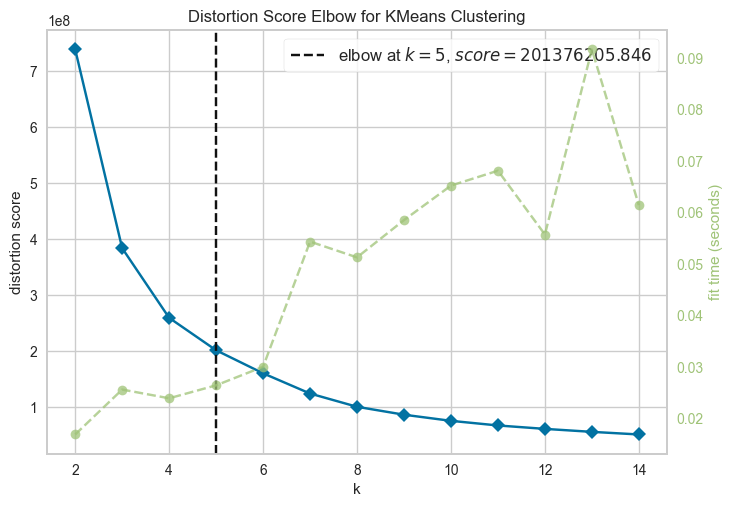

In [137]:
# Création Kmeans (avec 10 initialisations différentes)
model = KMeans(n_init=10, random_state=42)

# Création du visualiseur (metric = distorsion)
visualizer = KElbowVisualizer(model, k=k_range)

# Fit le modèle sur les données
visualizer.fit(X)

# Afficher le graphique
visualizer.poof()
plt.show()

Nous remarquons une inflexion de la courbe à **5 clusters**. 

### <span style='background:green; color:white'>b/ Calinski_harabasz</span>

Cette métrique de performance calcule le ratio entre la dispersion inter-cluster et la dispersion intra-cluster. Plus le score est élevé, plus les clusters sont denses et séparés.

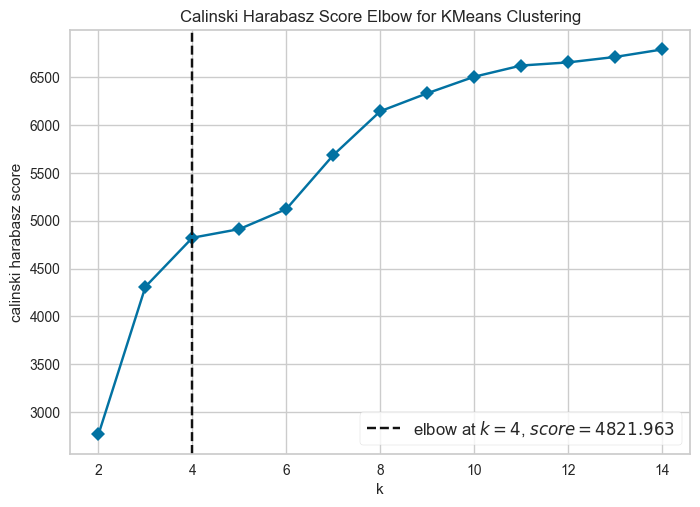

In [138]:
# Création Kmeans (avec 10 initialisations différentes)
model = KMeans(n_init=10, random_state=42)

# Création du visualiseur
visualizer = KElbowVisualizer(model, k=k_range, metric="calinski_harabasz", timings=False)

# Fit le modèle sur les données
visualizer.fit(X)

# Afficher le graphique
visualizer.poof()
plt.show()

Nous remarquons une inflexion de la courbe à **4 clusters**. 

### <span style='background:green; color:white'>c/ Silhouette</span>

La métrique de **silhouette** calcule la distance moyenne entre chaque point et tous les autres points du même cluster. Cette distance est ensuite comparée à la distance moyenne entre le point et tous les points d'un autre cluster. La silhouette est comprise entre -1 et 1. Plus la valeur est proche de 1, plus le point est proche des autres points de son cluster et éloigné des points des autres clusters.

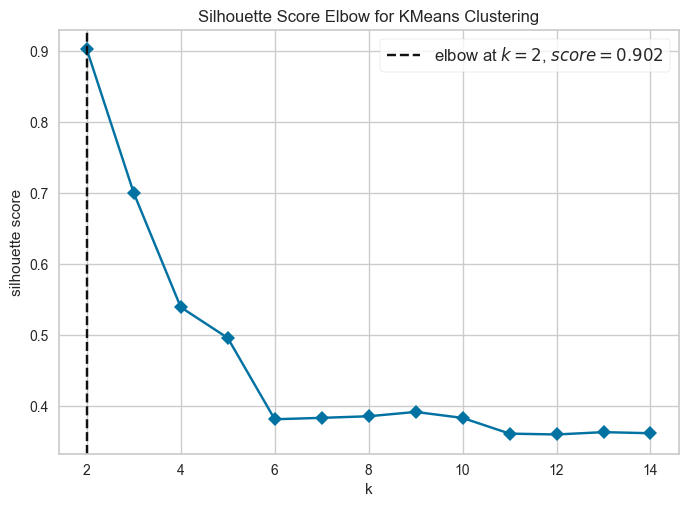

In [139]:
# Création Kmeans (avec 10 initialisations différentes)
model = KMeans(n_init=10, random_state=42)

# Création du visualiseur
visualizer = KElbowVisualizer(model, k=k_range, metric="silhouette", timings=False)

# Fit le modèle sur les données
visualizer.fit(X)

# Afficher le graphique
visualizer.poof()
plt.show()

Cette métrique ne retient que la valeur la plus haute soit **2 clusters**. 

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Notre intuition se tourne plutôt sur la métrique de distorsion qui permet d'avoir une segmentation convenable avec un clustering de 5 clusters. </div> 

## <span style='background:yellow; color:black'>2/ Analyse de la qualité du clustering</span>


### <span style='background:green; color:white'>a/ Visualisation de la silhouette</span>

Nous utilisons le visualisateur de silhouette pour visualiser les 5 clusters. 

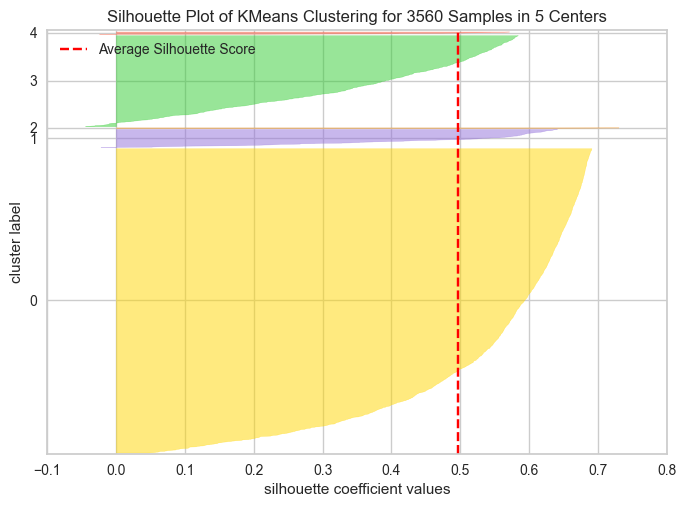

Cluster 4: 22 observations
Cluster 3: 778 observations
Cluster 2: 4 observations
Cluster 1: 154 observations
Cluster 0: 2602 observations


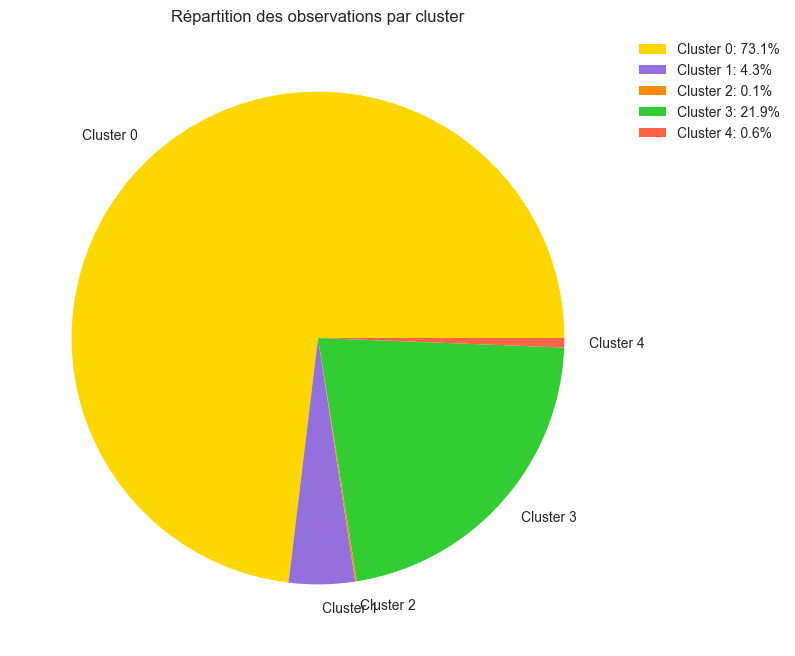

In [140]:
# Visualiser les 5 clusters
model_selected, labels = visualiser_clusters(X, n_clusters=5)

Nous remarquons qu'il y a un cluster qui détient plus de 70% des clients et deux autres qui en détiennent moins de 1%. 

### <span style='background:green; color:white'>b/ Indice de Davies-Bouldin</span>

La qualité du clustering peut être évalué avec l'indice de Davies-Bouldin. Cet indice indique la "similarité" moyenne entre les clusters, la "similarité" étant une mesure qui compare la distance entre les clusters à la taille des clusters eux-mêmes.

Plus le score est faible, plus les clusters sont denses et séparés. Par exemple, lorsqu'il est :
- <1 : le clustering est considéré comme bon. 
- <2 : le clustering est considéré comme moyen. 
- \>3 : le clustering est considéré comme mauvais. 

In [142]:
# Score de Davies-Bouldin
db_score = davies_bouldin_score(X, model_selected.labels_)
print(f"Le score de Davies-Bouldin est : {round(db_score, 2)}")

Le score de Davies-Bouldin est : 0.64



Le score de Davies-Bouldin évoque un bon clustering. 

### <span style='background:green; color:white'>c/ Moyenne par cluster</span>

Nous concatenons les données avec les labels de cluster.

In [143]:
# Dataframe avec la feature des clusters
df_rfm_cluster = pd.concat([X, pd.Series(model_selected.labels_, index=X.index, name='Cluster')], axis=1)

# Affichage
display(df_rfm_cluster.head(3))

,recence,frequence,montant,Cluster
customer_unique_id,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36,0
0058f300f57d7b93c477a131a59b36c3,159,3,271.60,0
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20,0


Nous affichons la moyenne des clusters pour chaque feature afin de vérifier la pertinence du clustering.

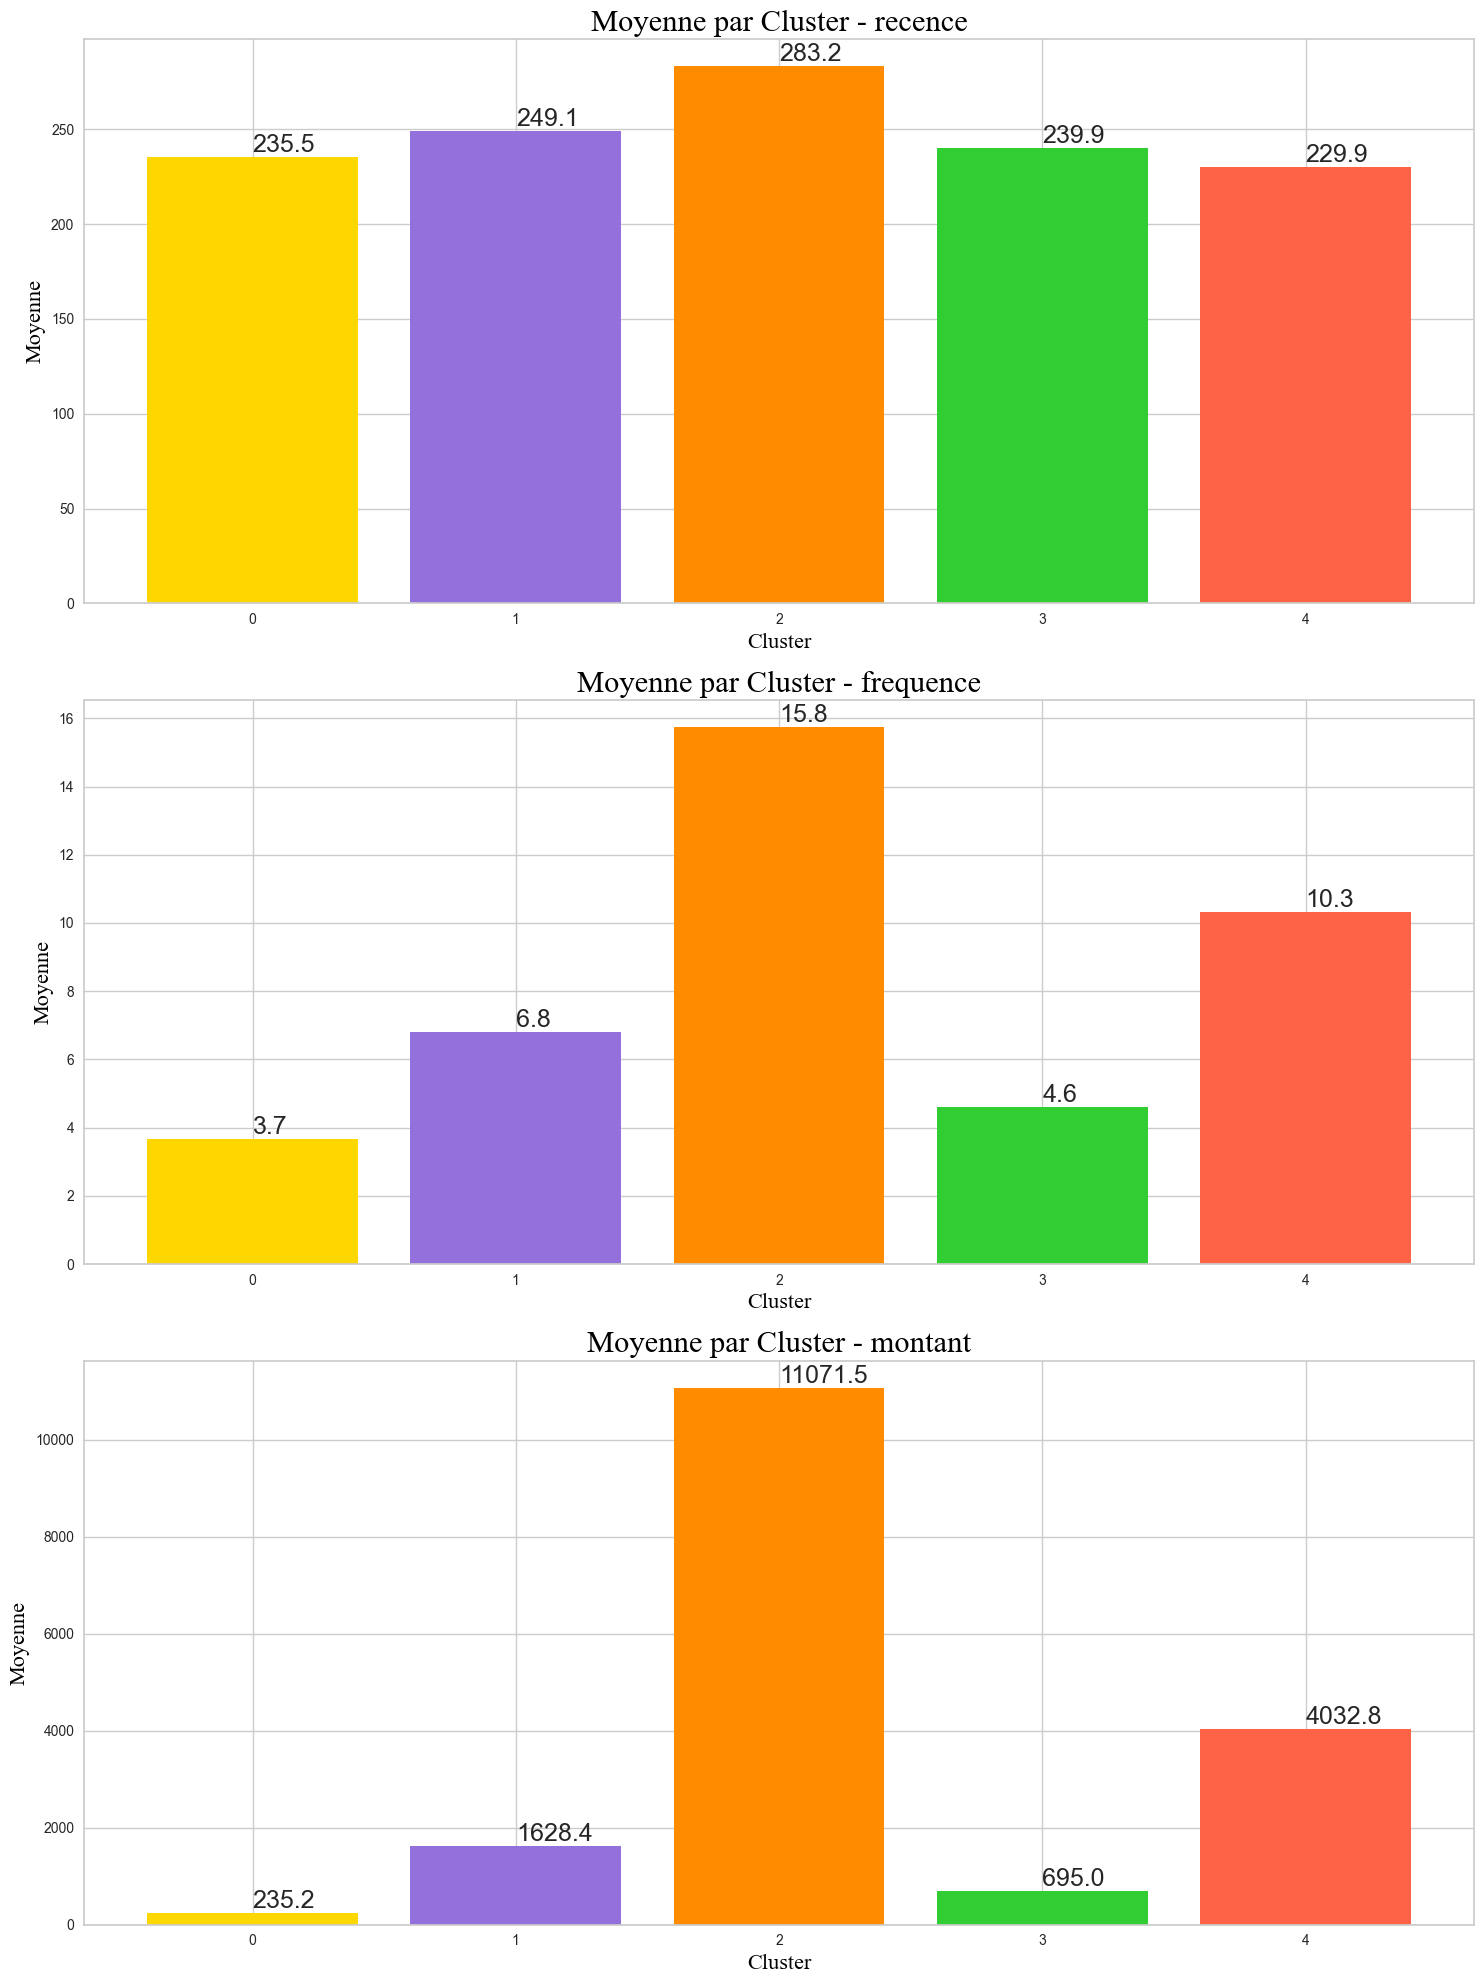

In [145]:
# Tracer la moyenne par cluster pour chaque feature
moyenne_par_cluster = tracer_moyenne_par_cluster(df_rfm_cluster)

Nous remarquons que les clusters présentes des valeurs de récence assez proches (entre 230 et 290 jours).

En revanche, les valeurs fréquence et de montant préentent des disparitées plus nettes. Celle-ci varient entre 3 et 16 fois pour la fréquence et entre 200 R$ et 11_000 R$ pour le montant.

### <span style='background:green; color:white'>d/ Radar par cluster</span>

Nous normalisons les moyennes des features pour pouvoir les comparer entre les clusters. 

In [146]:
# Créer un scaler
scaler = MinMaxScaler()

# Ajuster et transformer les données
moyenne_par_cluster_scaled = scaler.fit_transform(moyenne_par_cluster)

# Convertir le résultat en DataFrame
moyenne_par_cluster_scaled = pd.DataFrame(moyenne_par_cluster_scaled, columns=moyenne_par_cluster.columns)

# Affichage
display(moyenne_par_cluster_scaled)

,recence,frequence,montant
0,0.10566,0.00000,0.00000
1,0.36113,0.26076,0.12857
2,1.00000,1.00000,1.00000
3,0.18736,0.07798,0.04243
4,0.00000,0.55077,0.35045


Nous affichons un radar pour chaque cluster.

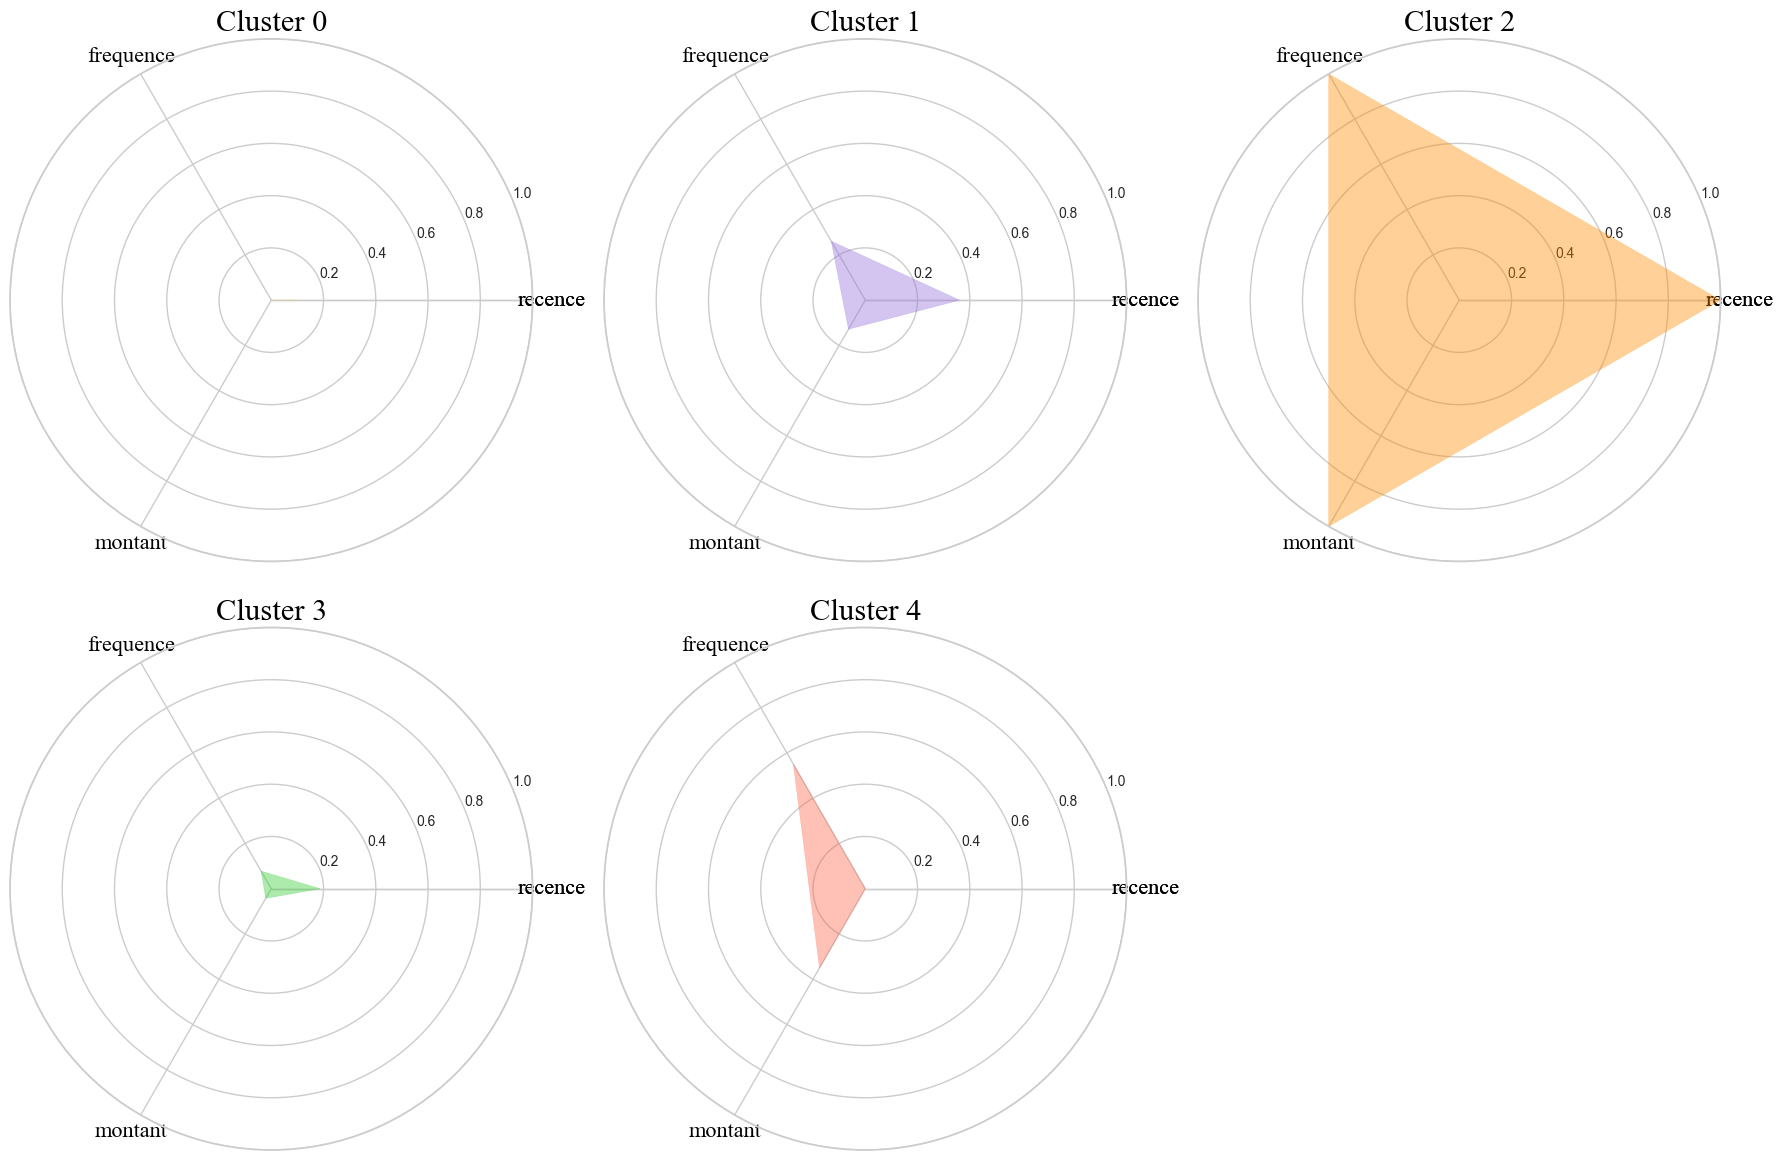

In [148]:
# Tracer un graphique radar pour chaque cluster
tracer_radar_par_cluster(moyenne_par_cluster_scaled, alpha=0.40)

Nous remarquons les particularités des différents clusters :
- Cluster 0 : les clients les plus récents qui ont fait le moins d'achat et dépensés le moins d'argent. 
- Cluster 1 : Les clients qui ne sont pas les plus récents qui ont fait beaucoup d'achat et dépensés beaucoup d'argent.
- Cluster 2 : les clients les plus anciens qui ont fait le plus d'achat et dépensés le plus d'argent. 
- Cluster 3 : Les clients qui ne sont pas les plus récents qui ont fait peu d'achat et dépensés peu d'argent.
- Cluster 4 : Les clients les plus récents qui ont fait beaucoup d'achat et dépensés beaucoup d'argent.

### <span style='background:green; color:white'>d/ Coefficient de Gini</span>

Le coefficient de Gini est une mesure de l'inégalité ou de la dispersion utilisée en économie, mais elle peut aussi être utilisée en clustering. Dans ce cas, le coefficient de Gini mesure à quel point les éléments sont répartis de manière inégale entre les différents clusters. 

Un coefficient de Gini de 0 signifie que tous les clusters ont le même nombre d'éléments, c'est-à-dire une répartition parfaitement égale. Un coefficient de Gini de 1 signifie qu'un cluster contient tous les éléments et que les autres clusters sont vides, c'est-à-dire une répartition parfaitement inégale.

Source : [Data Clustering Tutorial for Advanced](https://towardsdatascience.com/clustering-for-data-nerds-ebbfb7ed4090)<br>

In [149]:
# Calculer les coefficients de Gini pour chaque cluster
coef_gini = calcul_coef_gini(df_rfm_cluster, client_col_nom='customer_unique_id', cluster_col_nom='Cluster')

# Afficher les résultats
print("Cofficient de Gini des clusters :\n")
print(coef_gini)
print("\nCoefficient de Gini moyen: {0:.3f}".format(coef_gini.mean()))

Cofficient de Gini des clusters :

Cluster
0    0.99962
1    0.99351
2    0.75000
3    0.99871
4    0.95455
dtype: float64

Coefficient de Gini moyen: 0.939


Le coefficient de Gini proche de 1 évoque un clustering très inégalitaire. 

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Le clustering de la RFM avec 5 clusters est composé de : <br>
- 1er cluster de client qui ont fait un achat récent, qui ont une fréquence et une dépense faible (>70%) . <br>
- 2ème cluster de client qui ont fait un achat ancien et qui présentent une fréquence et une dépense intermédiaire (<5%). <br>
- 3ème cluster de client qui ont fait une achat très ancien et qui présentent une fréquence et une dépense importante (<0,5%). <br>
- 4ème cluster de client qui ont fait une achat assez récent et qui présentent une fréquence et une dépense faible (>20%). <br>
- 5ème cluster de client qui ont fait un achat récent, qui ont une fréquence et une dépense intermédiaire (<1%) . <br>


<b>Lien avec la RFM précédente: </b>
- 1er cluster : Loyaux?
- 2ème cluster : 
- 3ème cluster : 
- 4ème cluster :
- 5ème cluster :

</div> 

# <span style='background:blue'>Etape 2 : K-mean clustering RFM + Satisfaction</span>